In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from PIL import Image
import requests
from io import BytesIO
import re

In [ ]:
'item_weight': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'}

SyntaxError: illegal target for annotation (<ipython-input-46-b2251492be21>, line 1)

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/datasets/Amazon/train.csv')
test=pd.read_csv('/content/drive/MyDrive/datasets/Amazon/pseudo_test.csv')
# print(train)
print(train.shape)
print(test.shape)
entities=set(test['entity_name'])
print(entities)
inter=set(train['image_link']).intersection(set(test['image_link']))
print(len(inter))
for i in entities:
  print(i,test[test['entity_name']==i].shape)
print("done")
train_y=train['entity_value']
train_x=train.drop(['entity_value'],axis=1)
print(train_x)
li=[]
train=train.to_numpy()
test=test.to_numpy()
print(train)
cnt=0
train_w=np.array([i for i in train if i[2]=='item_weight' and ('[' not in i[3]) and ('to' not in i[3])][:2000])
test_w=np.array([i for i in test if i[3]=='item_weight'][:500])
print(train_w.shape)
for  i in train:
  if ('[' in i[3]) or ('to' in i[3]):
    li.append(i[2])
    cnt+=1
print(set(li),cnt)

(263859, 4)
(32, 4)
{'width', 'height', 'maximum_weight_recommendation', 'item_weight', 'voltage', 'wattage', 'item_volume', 'depth'}
0
width (4, 4)
height (4, 4)
maximum_weight_recommendation (4, 4)
item_weight (4, 4)
voltage (4, 4)
wattage (4, 4)
item_volume (4, 4)
depth (4, 4)
done
                                               image_link  group_id  \
0       https://m.media-amazon.com/images/I/61I9XdN6OF...    748919   
1       https://m.media-amazon.com/images/I/71gSRbyXmo...    916768   
2       https://m.media-amazon.com/images/I/61BZ4zrjZX...    459516   
3       https://m.media-amazon.com/images/I/612mrlqiI4...    459516   
4       https://m.media-amazon.com/images/I/617Tl40LOX...    731432   
...                                                   ...       ...   
263854  https://m.media-amazon.com/images/I/612J1R1xHl...    558806   
263855  https://m.media-amazon.com/images/I/61Blzh2+28...    470067   
263856  https://m.media-amazon.com/images/I/51MsegDL9V...    204245   
2638

In [ ]:
print(test_w.shape)

(500, 4)


In [ ]:
def load_and_preprocess_image(image_url):

  response = requests.get(image_url)
  img_array = np.frombuffer(response.content, np.uint8)
  img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (img_width, img_height))
  img = img / 255.0  # Normalize pixel values
  return img

In [ ]:
from PIL import Image
import pytesseract
import cv2
import os

In [ ]:
!apt-get install tesseract-ocr -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (6,019 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [ ]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 21.6 MB/s eta 0:00:00


In [ ]:
!pip install pytesseract

In [ ]:
def apply_ocr(img, config):
  return pytesseract.image_to_string(img, config=config).strip()
def convert_image(image):
  if len(image.shape) == 3 and image.shape[2] == 3:
    # Image is in color, convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  elif len(image.shape) == 2:
    # Image is already grayscale
    gray = image
  else:
    raise ValueError("Unexpected image format")
  return gray

In [ ]:
def ocr_with_rotation(roi, angle, threshold=False):
  if threshold:
    gray_roi = convert_image(roi)
    _, thresh = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img = thresh
  else:
    img = roi
  if angle != 0:
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC)
  text_psm6 = apply_ocr(img, '--psm 6')
  text_psm11 = apply_ocr(img, '--psm 11 --oem 3')
  digit_count_psm6 = sum(c.isdigit() for c in text_psm6)
  digit_count_psm11 = sum(c.isdigit() for c in text_psm11)
  return text_psm6 if digit_count_psm6 > digit_count_psm11 else text_psm11

In [ ]:
import cv2
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import pytesseract
from google.colab.patches import cv2_imshow  # Use cv2_imshow for Colab

# Load image from URL
# url = 'https://m.media-amazon.com/images/I/41CuF2+dwoL.jpg'

# url = 'https://m.media-amazon.com/images/I/41CuF2+dwoL.jpg'

# image_url = 'https://m.media-amazon.com/images/I/110EibNyclL.jpg'

# image_url = 'https://m.media-amazon.com/images/I/213wY3gUsmL.jpg'
# url = 'https://m.media-amazon.com/images/I/21+i52HRW4L.jpg'

# # url = 'https://m.media-amazon.com/images/I/51GzV0nG31L.jpg'
# # url = 'https://m.media-amazon.com/images/I/213wY3gUsmL.jpg'
# response = requests.get(url)
# img_data = response.content
# img = Image.open(BytesIO(img_data))

# # Convert the image to a format OpenCV understands (NumPy array)
#
def WDH(img):
  image = np.array(img)
  if len(image.shape) == 2:  # Grayscale image
      image_new = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  elif len(image.shape) == 3:  # Color image
      if image.shape[2] == 4:  # Image with alpha channel
          image_new = cv2.cvtColor(image, cv2.COLOR_RGBA2BGR)
      elif image.shape[2] == 3:  # RGB image
          image_new = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
      else:
          raise ValueError("Unexpected number of channels")
  else:
      raise ValueError("Unexpected image shape")


  # Convert the image to grayscale for easier processing
  gray = cv2.cvtColor(image_new, cv2.COLOR_BGR2GRAY)

  # Apply Gaussian blur to reduce noise
  gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

  # Apply adaptive thresholding
  thresh = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, 11, 2)

  # Find contours of all objects
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Check if any contours are found
  print(f"Number of contours found: {len(contours)}")

  # Initialize variables for the largest bounding box
  max_area = 0
  largest_bbox = None

  # Loop through all contours and find the largest bounding box
  for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)
      area = w * h  # Calculate area of the bounding box

      # Update largest bounding box if the current one is bigger
      if area > max_area:
          max_area = area
          largest_bbox = (x, y, w, h)

  # If a largest bounding box was found, draw it
  if largest_bbox is not None:
      x, y, w, h = largest_bbox
      cv2.rectangle(image_new, (x, y), (x + w, y + h), (0, 255, 0), 2)
      print(f"Largest bounding box: Width = {w} px, Height = {h} px")

      # Determine if the width is greater than the height
      # if w > h:
      #     print("The higher numerical value corresponds to the length (Width).")
      # else:
      #     print("The higher numerical value corresponds to the width (Height).")

  # Display the result with the largest bounding box
  # cv2_imshow(image_new)

  # ----------- PART 2: Line Detection and OCR ---------------



  gray = convert_image(image)
  # Apply Canny edge detection with adjusted thresholds
  edges = cv2.Canny(gray, 30, 120, apertureSize=3)

  # Detect lines using Hough Transform with tuned parameters
  lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=80, maxLineGap=15)

  # Classify lines into vertical and horizontal with a stricter classification
  vertical_lines = []
  horizontal_lines = []

  # Define a threshold for considering lines vertical or horizontal
  vertical_threshold = 10  # degrees
  horizontal_threshold = 10  # degrees

  for line in lines:
      x1, y1, x2, y2 = line[0]

      # Calculate the angle of the line in degrees
      angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))

      if abs(angle) > (90 - vertical_threshold):  # Almost vertical
          vertical_lines.append(line)
      elif abs(angle) < horizontal_threshold:  # Almost horizontal
          horizontal_lines.append(line)

  # Function to find the largest bounding box size from detected lines
  def get_largest_box(lines):
      max_width = 0
      max_height = 0
      for line in lines:
          x1, y1, x2, y2 = line[0]
          width = abs(x2 - x1)
          height = abs(y2 - y1)
          if width > max_width:
              max_width = width
          if height > max_height:
              max_height = height
      return max_width, max_height

  # Get the largest bounding box for both horizontal and vertical lines
  max_width, max_height = get_largest_box(lines)

  def extract_text_near_line(image, line, initial_padding=30, max_padding=100, step=30, color=(0, 255, 255), type_='height'):




      x1, y1, x2, y2 = line[0]
      prev_digit_count = 0
      best_text = ""
      best_digit_count = 0

      for padding in range(initial_padding, max_padding + 1, step):
          min_x = min(x1, x2) - padding
          max_x = max(x1, x2) + padding
          min_y = min(y1, y2) - padding
          max_y = max(y1, y2) + padding

          # Dynamically scale ROI based on the largest bounding box
          if type_ == 'height':
              min_x -= int(0.2 * max_width)
              max_x += int(0.2 * max_width)
          else:  # For length (horizontal)
              min_y -= int(0.2 * max_height)
              max_y += int(0.2 * max_height)

          min_x = max(0, min_x)
          min_y = max(0, min_y)
          max_x = min(image.shape[1], max_x)
          max_y = min(image.shape[0], max_y)

          roi = image[min_y:max_y, min_x:max_x]

          for rotation in [0, 90, 180, 270]:
              for use_threshold in [False, True]:
                  text = ocr_with_rotation(roi, rotation, use_threshold)
                  digit_count = sum(c.isdigit() for c in text)

                  if digit_count > best_digit_count:
                      best_digit_count = digit_count
                      best_text = text

          # Stop expanding if no new digits are detected
          if best_digit_count > prev_digit_count:
              prev_digit_count = best_digit_count
          else:
              break  # Stop expanding ROI when no more digits are found

      # If a valid text is found, draw a rectangle around the ROI
      if best_digit_count > 0:
          cv2.rectangle(image, (min_x, min_y), (max_x, max_y), color, 2)
          return best_text

      return None



  # Function to search through lines until text is found
  def extract_text_from_lines(image, lines, color, type_):
      for line in lines:
          text = extract_text_near_line(image, line, initial_padding=10, max_padding=100, step=20, color=color, type_=type_)
          if text:
              return text
      return "No valid text found"

  # Extract text from horizontal (length) and vertical (height) lines
  length_text = extract_text_from_lines(image, horizontal_lines, color=(255, 0, 0), type_='length')
  height_text = extract_text_from_lines(image, vertical_lines, color=(0, 0, 255), type_='height')

  # Print the detected dimensions
  print(f"Length: {length_text.strip()}")
  print(f"Height: {height_text.strip()}")
  # Optional: Visualize the lines and bounding boxes (for debugging)
  def draw_lines(image, lines, color=(0, 255, 0)):
      for line in lines:
          x1, y1, x2, y2 = line[0]
          cv2.line(image, (x1, y1), (x2, y2), color, 2)

  # Draw detected lines on a copy of the image for visualization
  output_image = image.copy()
  draw_lines(output_image, horizontal_lines, color=(255, 0, 0))  # Red for length
  draw_lines(output_image, vertical_lines, color=(0, 0, 255))    # Blue for height

  # Show the image with lines (optional)
  cv2_imshow(output_image)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  return (length_text.strip(),height_text.strip(),w,h)


In [ ]:
import cv2
import pytesseract
import numpy as np

# Load image
# img = cv2.imread('image_path.jpg')
def preprocess(img):
# Preprocessing steps
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Binarization
  _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
  # Noise removal
  denoised = cv2.medianBlur(binary, 3)
  # Deskewing
  coords = np.column_stack(np.where(denoised > 0))
  angle = cv2.minAreaRect(coords)[-1]
  if angle < -45:
      angle = -(90 + angle)
  else:
      angle = -angle
  (h, w) = denoised.shape[:2]
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  deskewed = cv2.warpAffine(denoised, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
  # Resizing
  resized = cv2.resize(deskewed, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)
  # Contrast enhancement
  enhanced = cv2.equalizeHist(resized)
  # Invert image if necessary
  # inverted = cv2.bitwise_not(enhanced)
  return enhanced
  # Tesseract OCR
# custom_config = r'-c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,%cmkgmm --oem 3 --psm 6'
# text = pytesseract.image_to_string(enhanced, config=custom_config, lang='eng')

# print("Extracted Text:", text)

In [ ]:
def useTes(roi,rotation):
  best_text=''
  best_digit_count=0
  for use_threshold in [False, True]:
    text = ocr_with_rotation(roi, rotation, use_threshold)
    digit_count = sum(c.isdigit() for c in text)
    if digit_count > best_digit_count:
      best_digit_count = digit_count
      best_text = text
  return best_text

In [ ]:
def extract_val()

In [ ]:
import requests
from io import BytesIO
from PIL import Image
import easyocr
import re
import cv2
import numpy as np
import pytesseract
# Function to download image from URL
def download_image_from_url(url):
    try:
      response = requests.get(url)
      img = Image.open(BytesIO(response.content))

      return img
    except Exception as e:
      return None
cnt=0
Testext=[]
# Function to convert PIL image to OpenCV format (Optional if using OpenCV for further processing)
def cvImage(d):
    try:
      global cnt
      # Convert PIL image to OpenCV format
      image,ent = d
      if image is None:
        print("yo")
      if image is None:
        return (None,None)
      print("cnt: ",cnt)
      cnt+=1
      image_cv = np.array(image)
      # extra=None
      # if ent in ['width','height','depth']:
      #   extra=WDH(image_cv)
      # image_cv=image
      # print(useTes(image_cv,0))
      # image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)
      image_cv = preprocess(image_cv)
      # custom_config = r'-c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,%cmkgmm --oem 3 --psm 6'
      # text = pytesseract.image_to_string(image_cv, config=custom_config, lang='eng')
      # global Testext
      # Testext.append(text)
      # print("Extracted Text:", text)
      # Step 3: Use EasyOCR for Text Recognition
      reader = easyocr.Reader(['en'])  # Initialize the EasyOCR reader

      # Step 4: Extract metrics and values using Regular Expressions
      def extract_measurements(text_list):
          pattern = r'(\d+(\.\d+)?\s?(cm|centimeters?|centimetres?|kg|kilograms?|mm|millimeters?|millimetres?|g|0z|grams?|km|kilometers?|kilometres?|l|liters?|litres?|ml|milliliters?|millilitres?|in|inches?|ft|feet|lb|pounds?|oz|ounces?|yd|yards?|mg|milligrams?|µg|micrograms?|t|tons?|tonnes?|m|meters?|metres?|cup|cl|centilitres?|cubic feet?|cubic inches?|dl|decilitres?|fl oz|fluid ounces?|gallons?|imperial gallons?|microlitres?|pints?|quarts?|kv|kilovolts?|mv|millivolts?|v|volts?|kw|kilowatts?|w|watts?))(?!\w)[^\w]*'

          measurements = []

          for text in text_list:
              text+=' '
              matches = re.findall(pattern, text.lower().replace(',', '.'))
              if matches:
                  measurements.extend(matches)
          return measurements

      # List to store all measurements for different rotations
      all_measurements = []
      all_recognized_texts = []

      # Loop through 0, 90, 180, and 270 degrees
      for angle in [0, 90, 180, 270]:
          # Rotate the image for each angle
          rotated_image = image.rotate(angle)
          rotated_image_cv = np.array(rotated_image)
          rotated_image_cv = cv2.cvtColor(rotated_image_cv, cv2.COLOR_RGB2BGR)

          # Get OCR result
          result = reader.readtext(np.array(rotated_image), detail=0)
          recognized_text = ' '.join(result).lower()

          # Extract measurements for this rotation
          measurements = extract_measurements(result)

          # Append the text and measurements from this rotation
          all_recognized_texts.append(recognized_text)
          all_measurements.extend(measurements)
      def extract_number_and_unit(text,unit):
      # Regular expression to match a floating-point or integer number followed by a unit
        if ' 0z' in text:
          number = float(re.match(r"([+-]?\d*\.?\d+)", text).group(1))
          return number, re.match(r"([+-]?\d*\.?\d+)", text).group(1), '0z'

      # Regular expression to match a floating-point or integer number followed by a unit
        match = re.match(r"([+-]?\d*\.?\d+)\s*([a-zA-Z]+(?:\d*)?)", text)
        if match:
            number = float(match.group(1))  # Extract number and convert to float

            return number, match.group(1), unit
        else:
            return 0, '', unit
      print(all_measurements)
      all_measurements = [extract_number_and_unit(i[0],i[-1]) for i in all_measurements]
      all_measurements.sort()


      # Output the recognized text and measurements for all rotations
      print("All Recognized Texts:", ' '.join(all_recognized_texts))
      print("All Extracted Measurements:", all_measurements)

      return all_measurements;
    except Exception as e:
      return []
# print(train_x['image_link'][63])
# # Example URL (replace with your image URL)

# downloaded_data = [(download_image_from_url(x[0]),x[2]) for x in train[9811:9812]]

# # Process each image and collect results
# output = [cvImage(d) for d in downloaded_data]

# print(cvImage(download_image_from_url('https://m.media-amazon.com/images/I/110EibNyclL.jpg')))

In [ ]:
# text = '1\n\n|\n\n4.00 inch (100mm)\n\n27.50 inch (700mm)'
def extract_dim(text):
# Regular expression to match numbers and their units
  pattern = r"([+-]?\d*\.?\d+)\s*([a-zA-Z]+(?:\d*)?)"
  # print(x)
  # Find all matches
  matches = re.findall(pattern, text)

  # Extract the relevant numbers and units
  extracted = []
  for match in matches:

      print(match)
      if match[0]:  # For the main number and unit
          extracted.append((float(match[0]),match[0], match[1]))

  return extracted

cnt:  0


/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

[]
All Recognized Texts: 3rcn 4gin - 7te 51 44mui eetcm 1 4 udgecs - ineseae lj83 3 '
All Extracted Measurements: []
Number of contours found: 16
Largest bounding box: Width = 419 px, Height = 17 px
Length: 2699 | wpe

Ia

——¥7)
Height: No valid text found


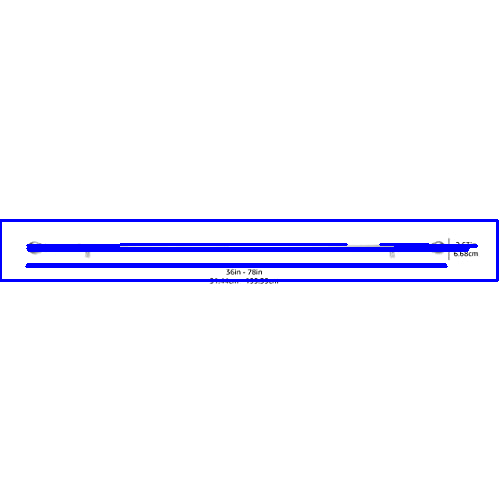

2699 | wpe

Ia

——¥7)
No valid text found
419
17
('2699 | wpe\n\nIa\n\n——¥7)', 'No valid text found', 419, 17)
[]
cnt:  1


/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

[('42cm', '', 'cm'), ('200cm', '', 'cm'), ('8l', '', 'l'), ('0oz', '', 'oz')]
All Recognized Texts: size width length one size 42cm/16.54" 200cm/78.74"  472*8l/l?0oz 479 91/l?zp az/5 juo 416ua7 yipim azis 9
All Extracted Measurements: [(0.0, '0', 'oz'), (8.0, '8', 'l'), (42.0, '42', 'cm'), (200.0, '200', 'cm')]
Number of contours found: 34
Largest bounding box: Width = 41 px, Height = 13 px
Length: 2000m/75. 14"
Height: No valid text found


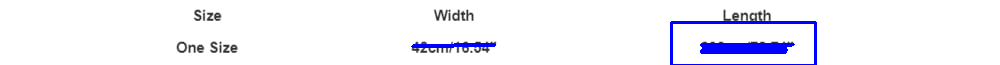

2000m/75. 14"
('2000', 'm')
No valid text found
41
13
('2000m/75. 14"', 'No valid text found', 41, 13)
[[2.0, '200', 'centimetre'], [0.42, '42', 'centimetre']]
cnt:  2
cnt:  3
cnt:  4


/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

[]
All Recognized Texts: ustabcm   
All Extracted Measurements: []
Number of contours found: 11
Largest bounding box: Width = 446 px, Height = 21 px
Length: No valid text found
Height: No valid text found


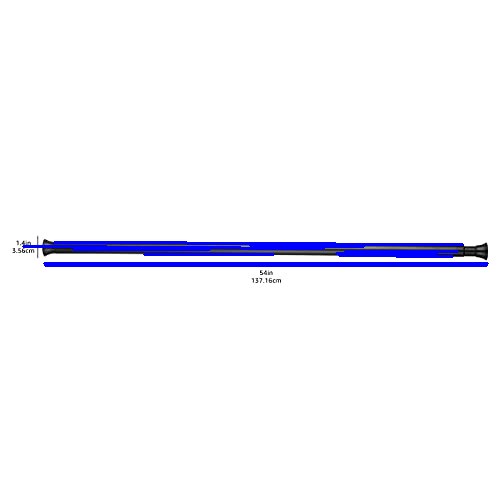

No valid text found
No valid text found
446
21
('No valid text found', 'No valid text found', 446, 21)
[]
cnt:  5


/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

[('10.50cm', '.50', 'cm'), ('90cm', '', 'cm'), ('0l', '', 'l')]
All Recognized Texts: size width length one size 10.50cm/4.13" 90cm/35.43"  4cp*9e/l?06 gel pilujos 0l azis juo 416ua7 yipim azi5 5 1
All Extracted Measurements: [(0.0, '0', 'l'), (10.5, '10.50', 'cm'), (90.0, '90', 'cm')]
Number of contours found: 31
Largest bounding box: Width = 33 px, Height = 12 px
Length: 10.50cm/4.13"
Height: No valid text found


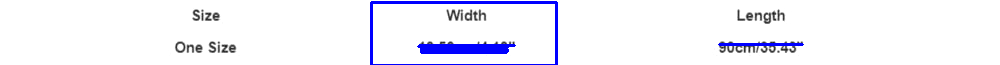

10.50cm/4.13"
('10.50', 'cm')
No valid text found
33
12
('10.50cm/4.13"', 'No valid text found', 33, 12)
[[0.9, '90', 'centimetre'], [0.105, '10.50', 'centimetre']]
cnt:  6


/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

[('0.6cm', '.6', 'cm'), ('41.6cm', '.6', 'cm'), ('03g', '', 'g')]
All Recognized Texts: j0,6cm 41.6cm 139,scm 1 03g' [ + wu?s* 69! wj9 0f 8 3
All Extracted Measurements: [(0.6, '0.6', 'cm'), (3.0, '03', 'g'), (41.6, '41.6', 'cm')]
Number of contours found: 44
Largest bounding box: Width = 354 px, Height = 122 px
Length: al °
— 7
139.50m
Height: 30.6em


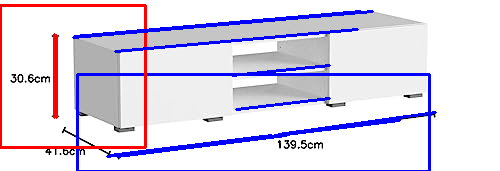

al °
— 7
139.50m
('139.50', 'm')
30.6em
('30.6', 'em')
354
122
('al °\n— 7\n139.50m', '30.6em', 354, 122)
[[0.41600000000000004, '41.6', 'centimetre'], [0.006, '0.6', 'centimetre']]
cnt:  7


/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

[('4.3in', '.3', 'in'), ('10 cm', '', 'cm')]
All Recognized Texts: 4.3in 10 cm  w) 01 ui €1 
All Extracted Measurements: [(4.3, '4.3', 'in'), (10.0, '10', 'cm')]
Number of contours found: 54
Largest bounding box: Width = 338 px, Height = 126 px
Length: No valid text found
Height: 4310)

10m


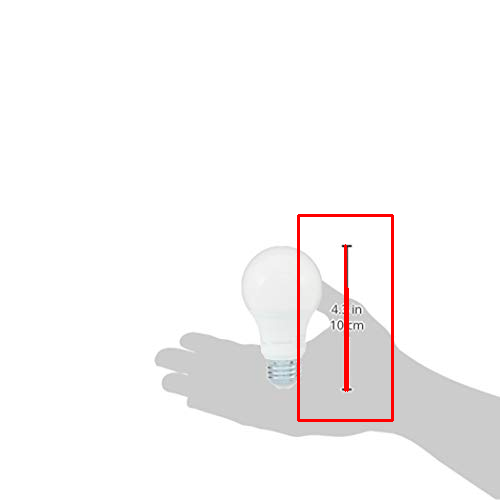

No valid text found
4310)

10m
('10', 'm')
338
126
('No valid text found', '4310)\n\n10m', 338, 126)
[[0.1, '10', 'centimetre'], [0.10922, '4.3', 'inch']]
cnt:  8


/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

[('4.7in', '.7', 'in')]
All Recognized Texts: 4.7in double-layer thick design fits perfectly under your glassware 5 4 l ] 2 1 1 [ 2 ajemsse/6 jnof japun apnoajuad s1y ubisap 4214} jakel-eiqnoa uil v # 5 } ! 8 1 1 } 1
All Extracted Measurements: [(4.7, '4.7', 'in')]
Number of contours found: 975
Largest bounding box: Width = 723 px, Height = 536 px
Length: HHICaAD Youn 1I9ApL-aiqnog
Height: 7


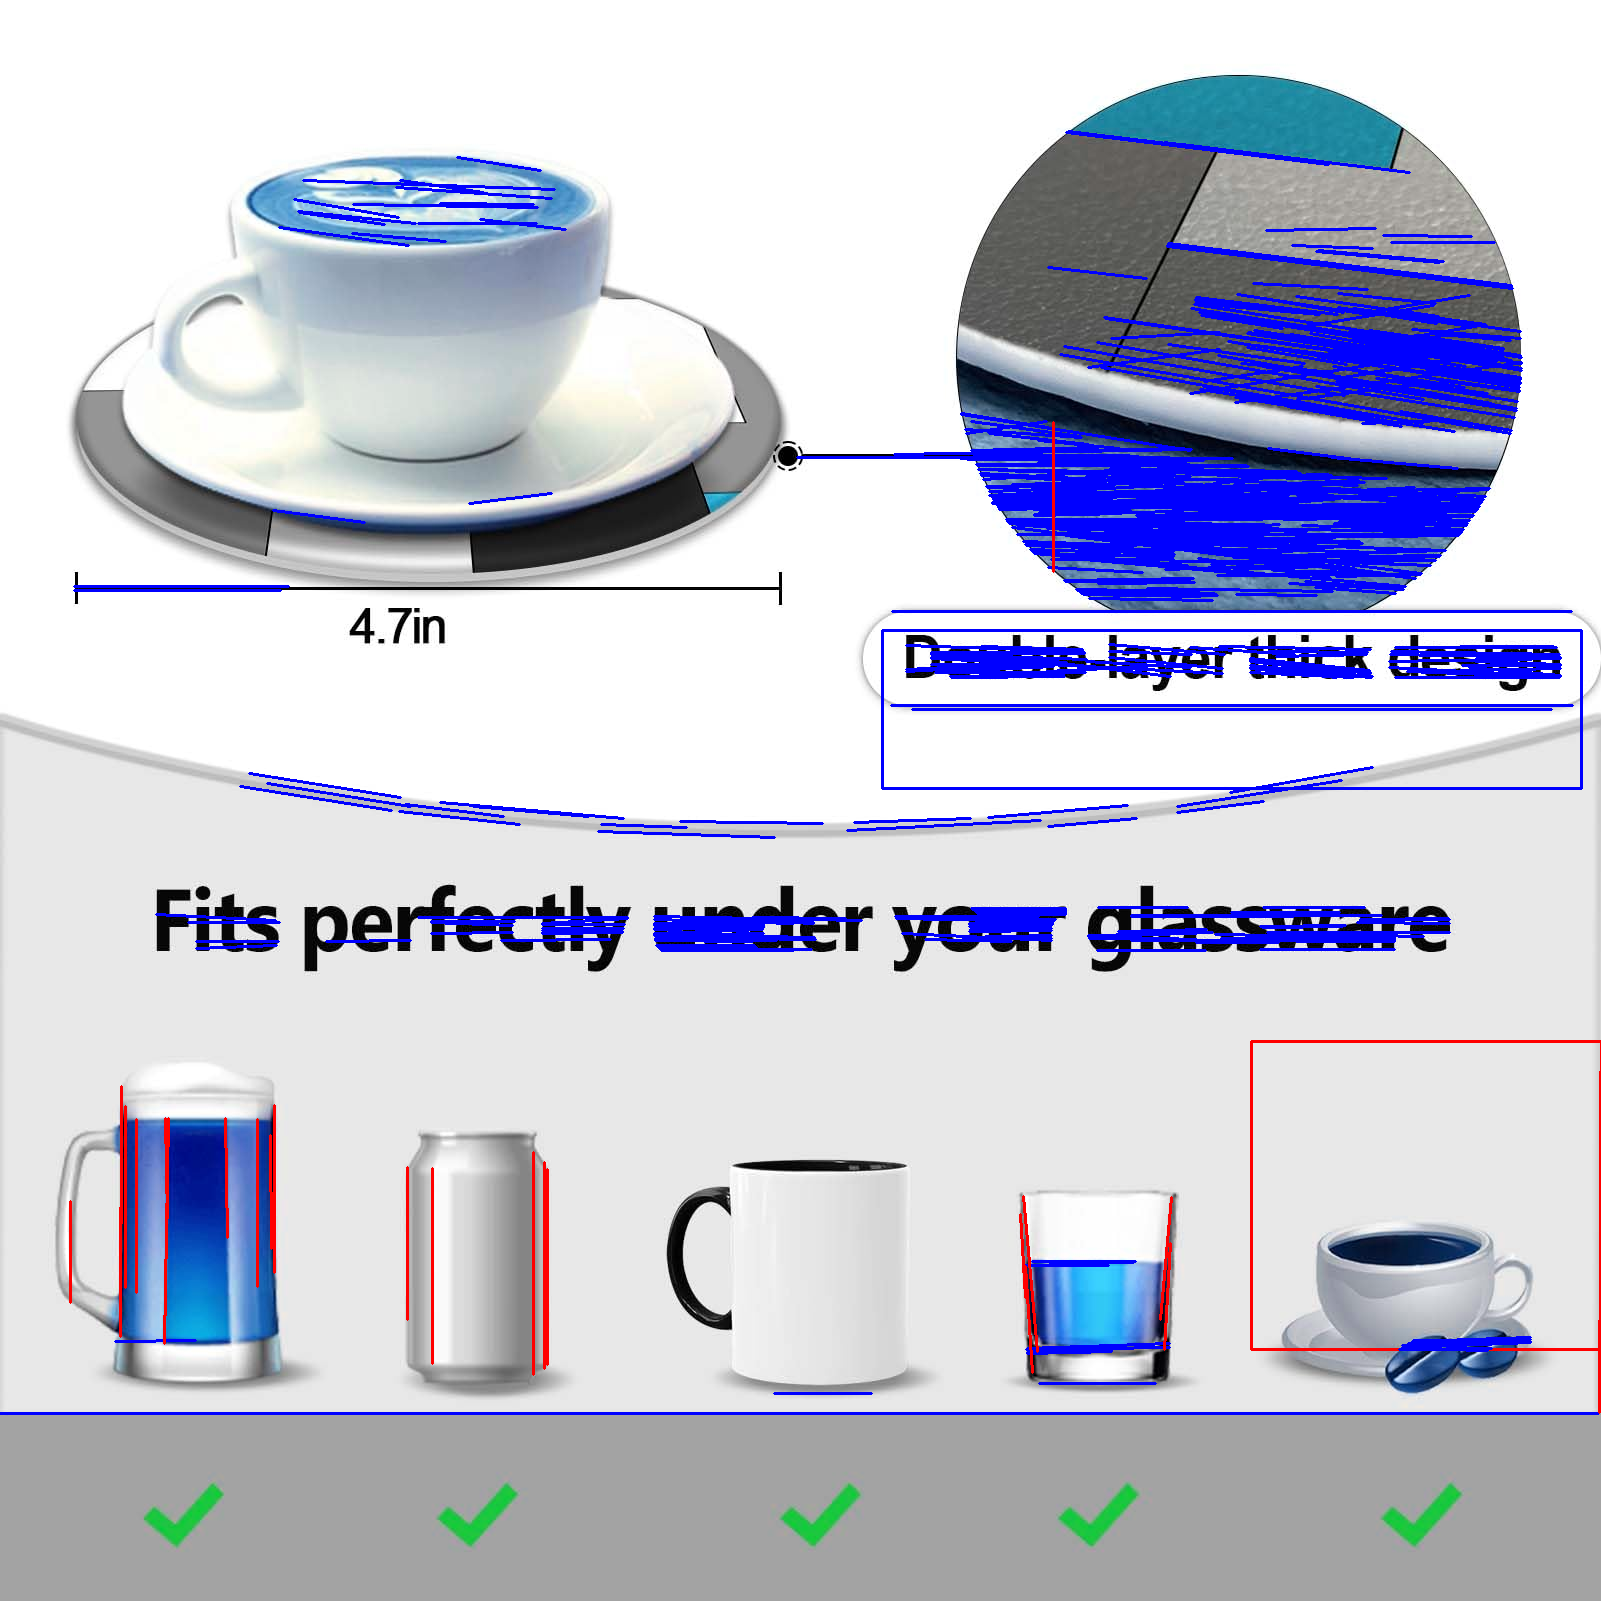

HHICaAD Youn 1I9ApL-aiqnog
('1', 'I9')
7
723
536
('HHICaAD Youn 1I9ApL-aiqnog', '7', 723, 536)
[[0.11938, '4.7', 'inch']]
cnt:  9
cnt:  10


/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

[('1.8 in', '.8', 'in'), ('4.5 cm', '.5', 'cm'), ('2.8 in', '.8', 'in'), ('7 cm', '', 'cm')]
All Recognized Texts: 1.8 in / 4.5 cm 2.8 in / 7 cm 8 7 2 q 8 ~ 3 wd l / u! 87 wd s'v / ui 8't 1 6 3 5 3
All Extracted Measurements: [(1.8, '1.8', 'in'), (2.8, '2.8', 'in'), (4.5, '4.5', 'cm'), (7.0, '7', 'cm')]
Number of contours found: 29
Largest bounding box: Width = 588 px, Height = 446 px
Length: 244

2.8 in/7cm
Height: 2
4


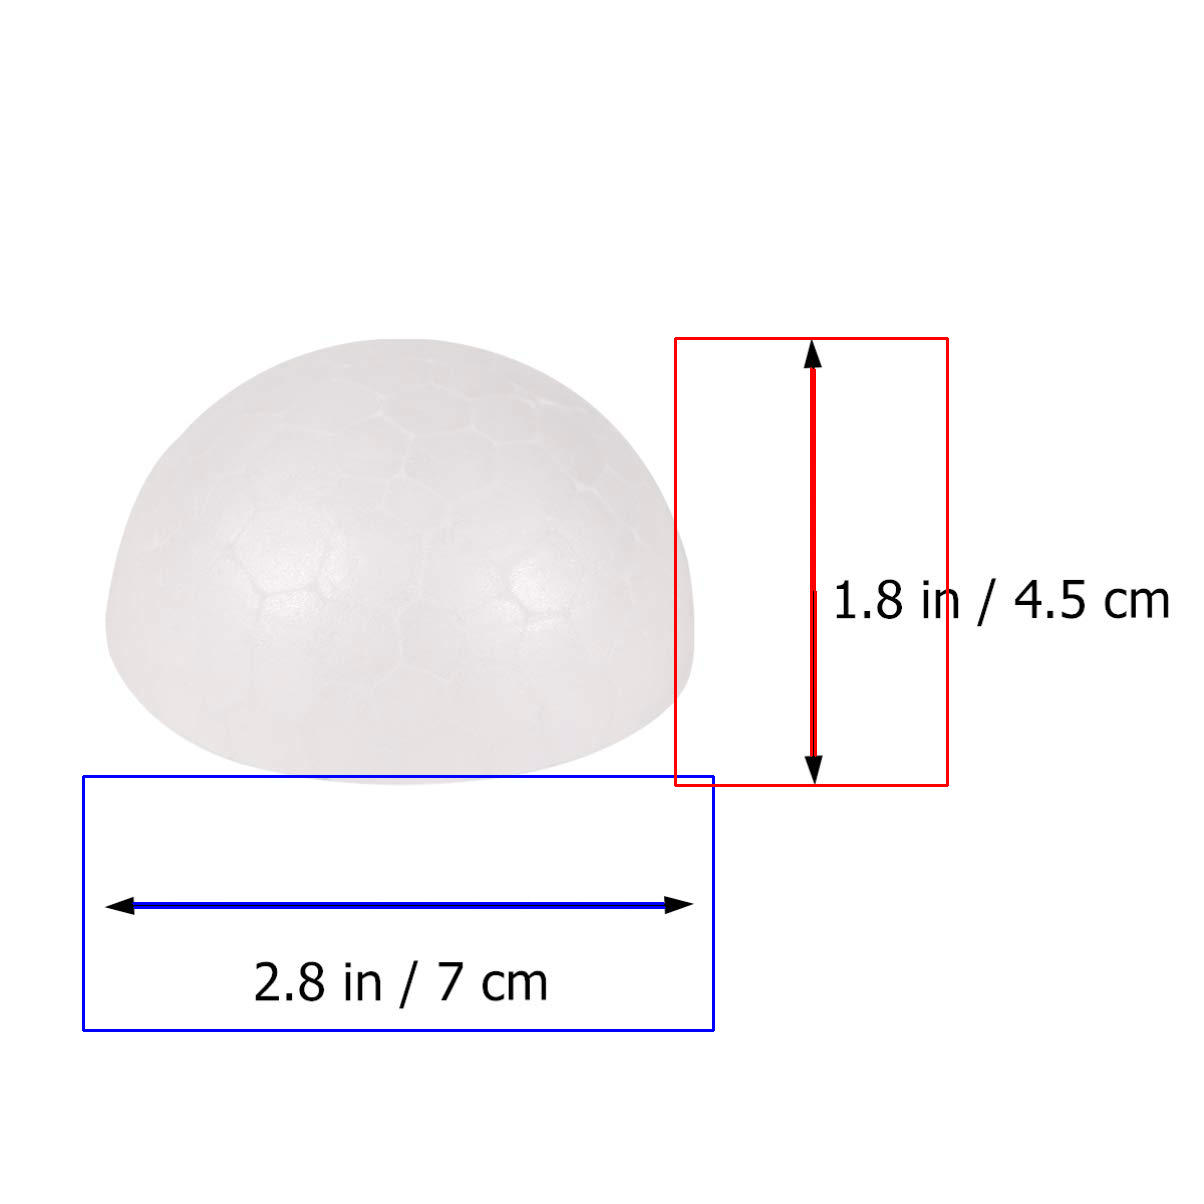

244

2.8 in/7cm
('2.8', 'in')
('7', 'cm')
2
4
588
446
('244\n\n2.8 in/7cm', '2\n4', 588, 446)
[[0.07, '7', 'centimetre'], [0.045, '4.5', 'centimetre'], [0.07111999999999999, '2.8', 'inch'], [0.04572, '1.8', 'inch']]
cnt:  11


/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

[('9.5cm', '.5', 'cm'), ('7cm', '', 'cm'), ('8cm', '', 'cm')]
All Recognized Texts: 9.5cm size 3 15pcs 15pcs 15pcs 9 5 8 { 7cm 3 8cm 8 t 8 of 40 8 8 c z cm length total e 3 % soasl sodsl sodsl 8 wjg'6 azis 5 w?l muci { 3 { { r ov jo 0 8 u38 3 ieiol 416u81 w?
All Extracted Measurements: [(7.0, '7', 'cm'), (8.0, '8', 'cm'), (9.5, '9.5', 'cm')]
Number of contours found: 426
Largest bounding box: Width = 506 px, Height = 346 px
Length: €
5
12
fon)
Height: 3 |
oO
00


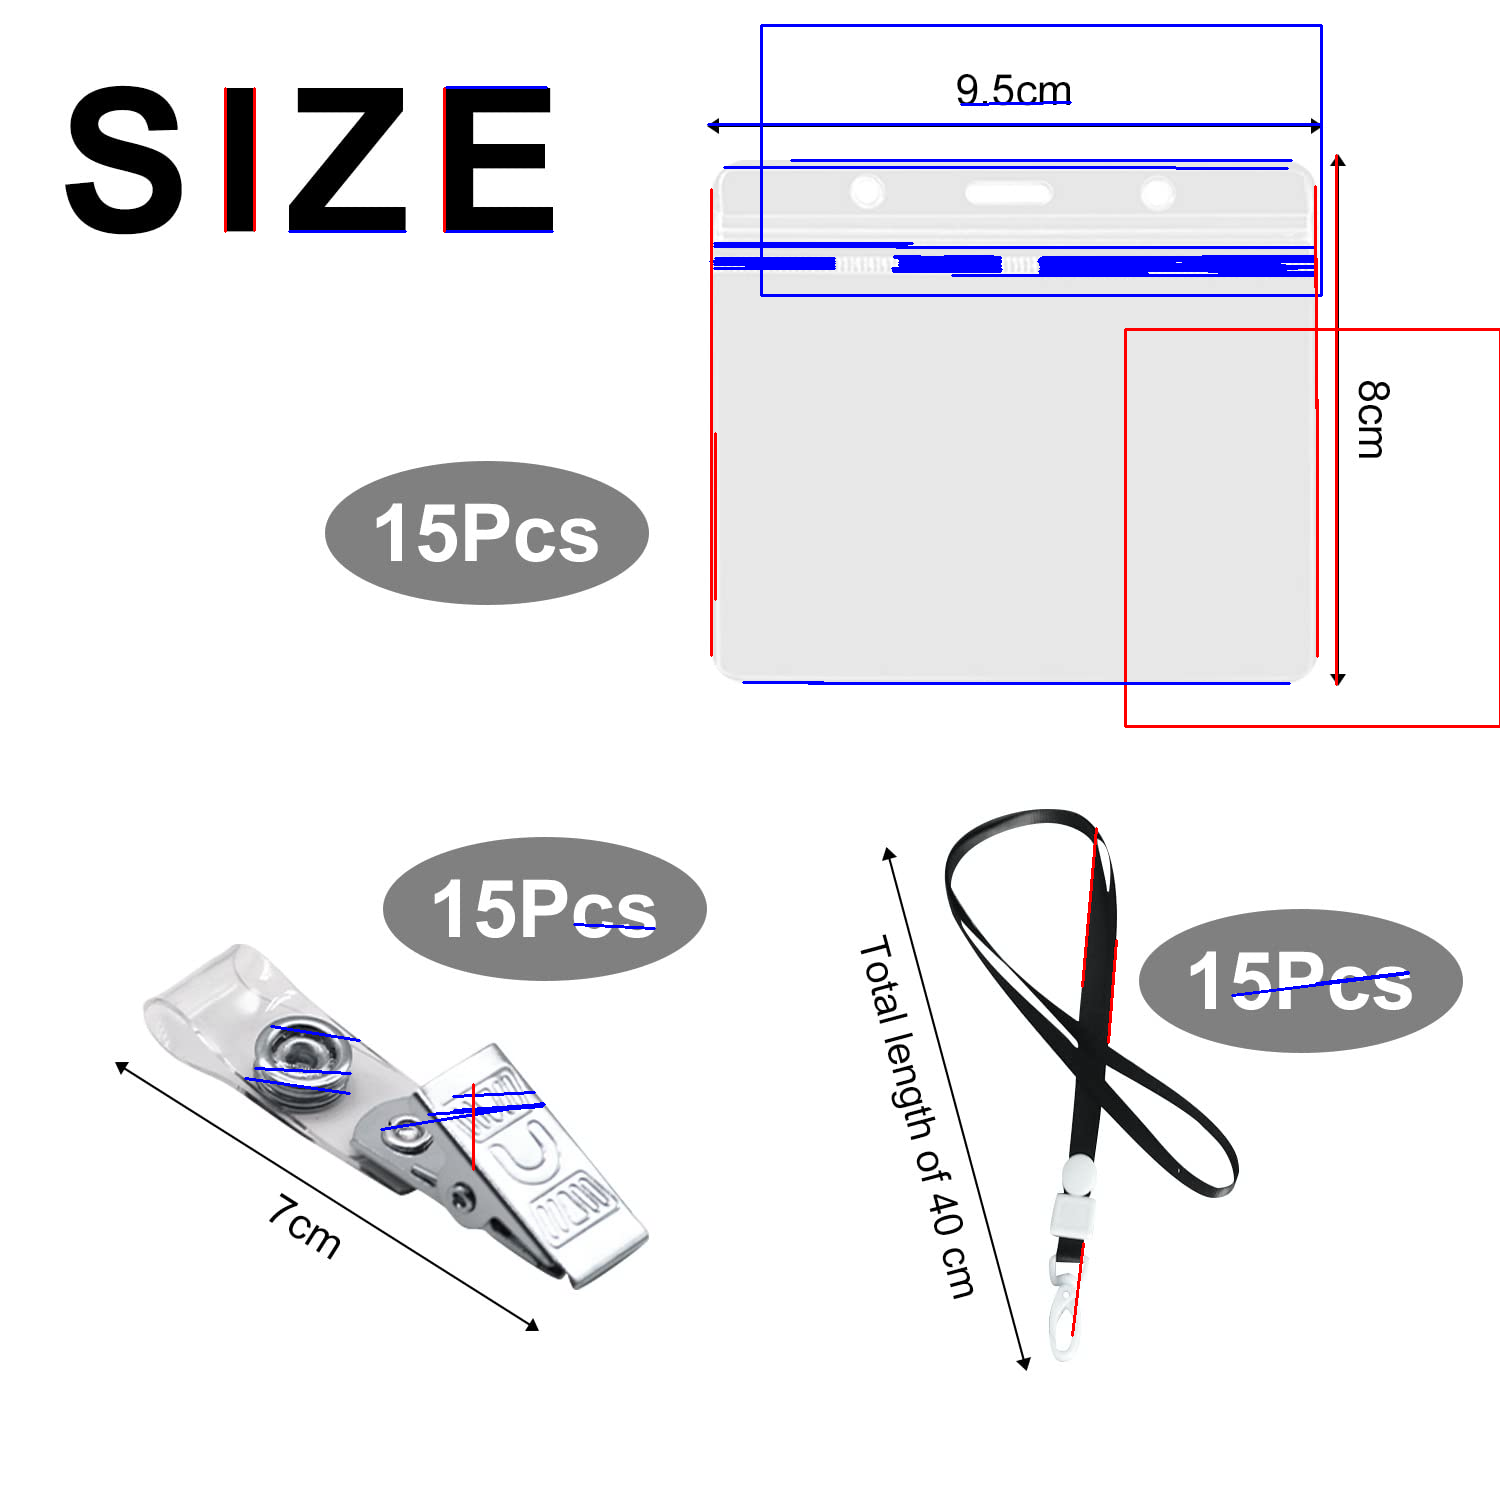

€
5
12
fon)
('12', 'fon')
3 |
oO
00
506
346
('€\n5\n12\nfon)', '3 |\noO\n00', 506, 346)
[[0.095, '9.5', 'centimetre'], [0.08, '8', 'centimetre'], [0.07, '7', 'centimetre']]
cnt:  12


/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

[('265 pounds', '', 'pounds')]
All Recognized Texts: ergonomic design recuce muscletengion and stfess lays compietel flat and has derlecbalance detween #imnessand soines$ high grade matrial high strenglh steel tubcs bracket and trianglc structure durable steel frame and oxford iabric can support up 265 pounds storage bag design for multi-scenarios features & sice pockei with cellphone section camping cot is perfect for adults or children; mcsh oulcr pccicitor cosy visibulity and comper ediontts or uncrpecicu nouse quest jno ceronmeme fashlights ti e 2 21 l 8} h u 1 u [ eml 1 1 1 [ 1 9 3  [  im uu i 1 1 silbuuseu0 uon swjl joljjiouc isanb jsnoy paloadxoun "sijoid a "sjoducj "kwpqisi ksej joj wo4sod mino 4sju "uaipiiy? siinp coieaien 70j buiduje) woassuqudia {lorood jpis ruuctd soijvn3js-iliw &oj nois3 9v83ivj01s r spunod 592 on vodons uc? juccipjro pue oc iqeinn 3mnjonns jbuei) puc joxpciq 579n1 /3315 ubuans 461h ivijlvwaavu) hdih {ouuc; pu:s uwju ujj jc ajugieojolad 5e4 pue jev siajald

In [ ]:
cache={}
finalAns=[]
for d in test:
  img=None
  link=d[1]
  if link in cache:
    img=cache[link]
  else:
    img=download_image_from_url(link)
    if img is None:
      finalAns.append('')
    cache[link]=[[],[],{},{},[]]
  out={}
  wdths=[]
  if(cache[link][0]==[]):
    # cache[link][1]=
    measure=cvImage((img,d[3]))


    converted_measure={'item_weight':(0,'',''),'width':(0,'',''),'voltage':(0,'',''),'wattage':(0,'',''),'item_volume':(0,'','')}
    for i in measure[::-1]:
      if(i[-1]=='t'):
        continue
      unit=normalized_units[i[-1]]
      if unit not in conversions:
        continue
      a=[i[0]*conversions[unit],i[1],unit]
      if( entity_types[unit]=='width'):
        wdths.append(a)
      best_val=converted_measure[entity_types[unit]]
      if best_val[0]<a[0]:
        best_val=a
      converted_measure[entity_types[unit]]=best_val
    cache[link][2]=converted_measure

  if d[3] in ['width','height','depth'] and cache[link][1]==[] :
    cache[link][1]=WDH(img)
    dims=[]
    for text in cache[link][1]:
      print(text)
      dim=extract_dim(str(text))
      best_val=[0,'','']
      for i in dim:
        if i[-1] not in normalized_units:
          continue
        unit=normalized_units[i[-1]]
        if unit not in conversions:
          continue
        a=(i[0]*conversions[unit],i[1],unit)

        if best_val[0]<a[0]:
          best_val=a
      dims.append(best_val)
    print(cache[link][1])
    w,h=cache[link][1][2:4]
    if w>h:
      if(dims[0][0]>dims[1][0]):
        dims[0],dims[1]=dims[1],dims[0]
    if w<h:
      if(dims[0][0]<dims[1][0]):
        dims[0],dims[1]=dims[1],dims[0]
    best_wdth=[0,'0','']
    print(wdths)
    wdths.sort()
    wdths=wdths[::-1]
    for wdth in wdths:
      if wdth[1]==dims[0][1]:
        continue
      if wdth[1]==dims[1][1]:
        continue
      best_wdth=wdth
      break
    if(best_wdth[0]==0):
      best_wdth=dims[1]
    cache[link][3]={'width':dims[0],'height':dims[1],'depth':best_wdth}
  if d[3] in ['width','height','depth']:
    finalAns.append(cache[link][3][d[3]])
  else:
    if d[3]=='maximum_weight_recommendation':
      finalAns.append(cache[link][2]['item_weight'])
    else :
      finalAns.append(cache[link][2][d[3]])
print(finalAns)
print(cache)









In [ ]:
for c in cache:
  print(c, cache[c])
  print()

https://m.media-amazon.com/images/I/110EibNyclL.jpg [[], ('2699 | wpe\n\nIa\n\n——¥7)', 'No valid text found', 419, 17), {'item_weight': (0, '', ''), 'width': (0, '', ''), 'voltage': (0, '', ''), 'wattage': (0, '', ''), 'item_volume': (0, '', '')}, {'width': [0, '', ''], 'height': [0, '', ''], 'depth': [0, '', '']}, []]

https://m.media-amazon.com/images/I/11TU2clswzL.jpg [[], ('2000m/75. 14"', 'No valid text found', 41, 13), {'item_weight': (0, '', ''), 'width': (0, '', ''), 'voltage': (0, '', ''), 'wattage': (0, '', ''), 'item_volume': (0, '', '')}, {'width': [0, '', ''], 'height': (2000.0, '2000', 'metre'), 'depth': [2.0, '200', 'centimetre']}, []]

https://m.media-amazon.com/images/I/11lshEUmCrL.jpg [[], ('No valid text found', 'No valid text found', 446, 21), {'item_weight': (0, '', ''), 'width': (0, '', ''), 'voltage': (0, '', ''), 'wattage': (0, '', ''), 'item_volume': (0, '', '')}, {'width': [0, '', ''], 'height': [0, '', ''], 'depth': [0, '', '']}, []]

https://m.media-amazon.c

In [ ]:
normalized_units = {
    'cm': 'centimetre',
    'centimeter': 'centimetre',
    'centimeters': 'centimetre',
    'centimetre': 'centimetre',
    'centimetres': 'centimetre',
    'kg': 'kilogram',
    'kilogram': 'kilogram',
    'kilograms': 'kilogram',
    'mm': 'millimetre',
    'millimeter': 'millimetre',
    'millimeters': 'millimetre',
    'millimetre': 'millimetre',
    'millimetres': 'millimetre',
    'g': 'gram',
    'gram': 'gram',
    'grams': 'gram',
    'km': 'kilometre',
    'kilometer': 'kilometre',
    'kilometers': 'kilometre',
    'kilometre': 'kilometre',
    'kilometres': 'kilometre',
    'l': 'litre',
    'liter': 'litre',
    'liters': 'litre',
    'litre': 'litre',
    'litres': 'litre',
    'ml': 'millilitre',
    'milliliter': 'millilitre',
    'milliliters': 'millilitre',
    'millilitre': 'millilitre',
    'millilitres': 'millilitre',
    'in': 'inch',
    'inch': 'inch',
    'inches': 'inch',
    'ft': 'foot',
    'foot': 'foot',
    'feet': 'foot',
    'lb': 'pound',
    'pound': 'pound',
    'pounds': 'pound',
    'oz': 'ounce',
    '0z':'ounce',
    'ounce': 'ounce',
    'ounces': 'ounce',
    'yd': 'yard',
    'yard': 'yard',
    'yards': 'yard',
    'mg': 'milligram',
    'milligram': 'milligram',
    'milligrams': 'milligram',
    'µg': 'microgram',
    'microgram': 'microgram',
    'micrograms': 'microgram',
    't': 'ton',
    'ton': 'ton',
    'tons': 'ton',
    'tonne': 'ton',
    'tonnes': 'ton',
    'm': 'metre',
    'meter': 'metre',
    'meters': 'metre',
    'metre': 'metre',
    'metres': 'metre',
    'cup': 'cup',
    'cl': 'centilitre',
    'centilitre': 'centilitre',
    'centilitres': 'centilitre',
    'cubic foot': 'cubic foot',
    'cubic feet': 'cubic foot',
    'cubic inch': 'cubic inch',
    'cubic inches': 'cubic inch',
    'dl': 'decilitre',
    'decilitre': 'decilitre',
    'decilitres': 'decilitre',
    'fl oz': 'fluid ounce',
    'fluid ounce': 'fluid ounce',
    'fluid ounces': 'fluid ounce',
    'gallon': 'gallon',
    'gallons': 'gallon',
    'imperial gallon': 'imperial gallon',
    'imperial gallons': 'imperial gallon',
    'litre': 'litre',
    'litres': 'litre',
    'microlitre': 'microlitre',
    'microlitres': 'microlitre',
    'pint': 'pint',
    'pints': 'pint',
    'quart': 'quart',
    'quarts': 'quart',
    'kv': 'kilovolt',
    'kilovolt': 'kilovolt',
    'kilovolts': 'kilovolt',
    'mv': 'millivolt',
    'millivolt': 'millivolt',
    'millivolts': 'millivolt',
    'v': 'volt',
    'volt': 'volt',
    'volts': 'volt',
    'kw': 'kilowatt',
    'kilowatt': 'kilowatt',
    'kilowatts': 'kilowatt',
    'w': 'watt',
    'watt': 'watt',
    'watts': 'watt'
}


In [ ]:
entity_types = {
    'centimetre': 'width',
    'foot': 'width',
    'inch': 'width',
    'metre': 'width',
    'millimetre': 'width',
    'yard': 'width',

    'gram': 'item_weight',
    'kilogram': 'item_weight',
    'microgram': 'item_weight',
    'milligram': 'item_weight',
    'ounce': 'item_weight',
    'pound': 'item_weight',
    'ton': 'item_weight',

    'kilovolt': 'voltage',
    'millivolt': 'voltage',
    'volt': 'voltage',

    'kilowatt': 'wattage',
    'watt': 'wattage',

    'centilitre': 'item_volume',
    'cubic foot': 'item_volume',
    'cubic inch': 'item_volume',
    'cup': 'item_volume',
    'decilitre': 'item_volume',
    'fluid ounce': 'item_volume',
    'gallon': 'item_volume',
    'imperial gallon': 'item_volume',
    'litre': 'item_volume',
    'microlitre': 'item_volume',
    'millilitre': 'item_volume',
    'pint': 'item_volume',
    'quart': 'item_volume'
}


In [ ]:
conversions = {

    'centimetre': 0.01,      # 1 cm = 0.01 m
    'foot': 0.3048,          # 1 ft = 0.3048 m
    'inch': 0.0254,          # 1 inch = 0.0254 m
    'metre': 1,              # 1 m = 1 m (base unit)
    'millimetre': 0.001,     # 1 mm = 0.001 m
    'yard': 0.9144,           # 1 yard = 0.9144 m



        'gram': 1,               # 1 g = 1 g (base unit)
        'kilogram': 1000,        # 1 kg = 1000 g
        'microgram': 1e-6,       # 1 µg = 0.000001 g
        'milligram': 0.001,      # 1 mg = 0.001 g
        'ounce': 28.3495,        # 1 ounce = 28.3495 g
        'pound': 453.592,        # 1 lb = 453.592 g
        'ton': 1e6               # 1 ton = 1,000,000 g
   ,


        'kilovolt': 1000,        # 1 kV = 1000 V
        'millivolt': 0.001,      # 1 mV = 0.001 V
        'volt': 1                # 1 V = 1 V (base unit)
    ,


        'kilowatt': 1000,        # 1 kW = 1000 W
        'watt': 1                # 1 W = 1 W (base unit)
    ,


        'centilitre': 0.01,      # 1 cl = 0.01 L
        'cubic foot': 28.3168,   # 1 cubic foot = 28.3168 L
        'cubic inch': 0.0163871, # 1 cubic inch = 0.0163871 L
        'cup': 0.236588,         # 1 cup = 0.236588 L
        'decilitre': 0.1,        # 1 dl = 0.1 L
        'fluid ounce': 0.0295735,# 1 fl oz = 0.0295735 L
        'gallon': 3.78541,       # 1 gallon = 3.78541 L
        'imperial gallon': 4.54609,# 1 imperial gallon = 4.54609 L
        'litre': 1,              # 1 L = 1 L (base unit)
        'microlitre': 1e-6,      # 1 µL = 0.000001 L
        'millilitre': 0.001,     # 1 mL = 0.001 L
        'pint': 0.473176,        # 1 pint = 0.473176 L
        'quart': 0.946353        # 1 quart = 0.946353 L

}


In [ ]:
correct=0
for i in range(len(convertedMeasures)):
  # pred=' '.join(convertedMeasures[i][train_x['entity_name'][i]][1:])
  if convertedMeasures[i][train_x['entity_name'][i]][1]=='':
    print('true: ',train_y[i],'predicted: ')
  else:
    v,s,u=convertedMeasures[i][train_x['entity_name'][i]]
    pred=str(float(s))+' '+u
    if u=='milligram':
      pred=s+' '+u

    print('true: ',train_y[i],'predicted: ',pred)
    correct+=1 if train_y[i]==pred else 0
print(correct,correct/len(convertedMeasures))

true:  500.0 gram predicted:  500.0 gram
true:  1.0 cup predicted: 
true:  0.709 gram predicted:  0.709 gram
true:  0.709 gram predicted:  0.51 gram
true:  1400 milligram predicted:  1400 milligram
true:  1400 milligram predicted:  1400 milligram
true:  1400 milligram predicted:  2.0 gram
true:  1400 milligram predicted: 
true:  1400 milligram predicted:  1400 milligram
true:  1400 milligram predicted:  2.0 gram
true:  30.0 kilogram predicted:  30.0 kilogram
true:  10 kilogram to 15 kilogram predicted:  45.0 kilogram
true:  3.53 ounce predicted: 
true:  3.53 ounce predicted:  3.53 ounce
true:  53 ounce predicted:  3.53 ounce
true:  100 gram predicted: 
true:  200 gram predicted: 
true:  1 kilogram predicted:  280.0 gram
true:  200 gram predicted:  31.5 gram
true:  200 gram predicted:  20.0 gram
true:  200 gram predicted: 
true:  4.0 gallon predicted:  4.0 litre
true:  2.7 gram predicted:  2.7 gram
true:  112 gram predicted:  112.0 gram
true:  4.1 kilogram predicted:  44.0 kilogram
true